# Deep denoising auto-encoder and MLP based multi-output regression on TCGA multi-omics data
## DNA Methylation and CNA to RNA-Seq

# Setting environment

Seeding the random number generators

In [ ]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            # have reproducible behavior for certain hash-based operations.
import os
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
import numpy as np
np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
import random as rn
rn.seed(12345)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
import tensorflow.compat.v1 as tf
tf.set_random_seed(1234)

# Force TensorFlow to use single thread.
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
from tensorflow.compat.v1.keras import backend as K

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)


tf.compat.v1.keras.backend.set_session(sess);

K.set_session(sess)

Importing libraries

In [ ]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

In [ ]:
def rSquared(true,predicted):
    cols = predicted.shape[1]
    rsq = np.zeros(shape=(cols), dtype = np.float32)
    for j in range(cols):
        rsq[j] = r2_score(true[:,j], predicted[:,j])
    return rsq

# Loading data

Importing data from pre-processed csv files (Change paths accordingly)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ls "/content/drive/My Drive/CS309_group_project/Preprocessed_Data/"

In [ ]:
preprocessed_DNAMeth = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_preprocessed_DNAMeth.csv')
preprocessed_RNASeq = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_preprocessed_RNASeq.csv')
preprocessed_CNA = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_preprocessed_CNA.csv')
labels = pd.read_csv('/content/drive/My Drive/CS309_group_project/Preprocessed_Data/LIHC_labels.csv')

In [ ]:
x1 = preprocessed_DNAMeth
y = preprocessed_RNASeq

Concatenating Methylation and CNV features

In [ ]:
z = pd.DataFrame(x1)


Splitting the data into training and testing datasets

In [ ]:
x_train, x_test, y_train, y_test, labels_train, labels_test = train_test_split(z, y, labels, test_size=0.2)

Scaling the data within [0-1] range

In [ ]:
scalar = MinMaxScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

Adding gaussian noise

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(0.0, 1.0, x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(0.0, 1.0, x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Dimension Reduction/Feature Extraction using DDAE

Setting the no. of input and output neurons

In [ ]:
num_in_neurons = z.shape[1]
num_out_neurons = y.shape[1]

In [ ]:
# Auto-encoder to extract features from DNA Methylation and CNV data

with tf.device('/gpu:0'):
    # this is the size of our encoded representations
    encoding_dim1 = 500
    encoding_dim2 = 200

    lambda_act = 0.0001
    lambda_weight = 0.001
    # this is our input placeholder
    input_data = Input(shape=(num_in_neurons,))
    # first encoded representation of the input
    encoded = Dense(encoding_dim1, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder1')(input_data)
    # second encoded representation of the input
    encoded = Dense(encoding_dim2, activation='relu', activity_regularizer=regularizers.l1(lambda_act), kernel_regularizer=regularizers.l2(lambda_weight), name='encoder2')(encoded)
    # first lossy reconstruction of the input
    decoded = Dense(encoding_dim1, activation='relu', name='decoder1')(encoded)
    # the final lossy reconstruction of the input
    decoded = Dense(num_in_neurons, activation='sigmoid', name='decoder2')(decoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_data, outputs=decoded)

    myencoder = Model(inputs=input_data, outputs=encoded)
    autoencoder.compile(optimizer='sgd', loss='mse')
    # training
    print('training the autoencoder')
    autoencoder.fit(x_train_noisy, x_train,
                    epochs=25,
                    batch_size=8,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))
    autoencoder.trainable = False   #freeze autoencoder weights

training the autoencoder
Epoch 1/25
41/41 [==============================] - 1s 8ms/step - loss: 1.3670 - val_loss: 1.3657
Epoch 2/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3603 - val_loss: 1.3597
Epoch 3/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3549 - val_loss: 1.3548
Epoch 4/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3504 - val_loss: 1.3507
Epoch 5/25
41/41 [==============================] - 0s 4ms/step - loss: 1.3466 - val_loss: 1.3472
Epoch 6/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3433 - val_loss: 1.3440
Epoch 7/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3402 - val_loss: 1.3411
Epoch 8/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3375 - val_loss: 1.3384
Epoch 9/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3348 - val_loss: 1.3359
Epoch 10/25
41/41 [==============================] - 0s 5ms/step - loss: 1.3324 - val_loss: 1

# Regression using MLP

In [ ]:
# MLP Multi-output Regression code goes here...

num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)

    y_pred = mlpRegressor.predict(x_test)

    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))

training the MLP multi-output regressor
Epoch 1/50
41/41 [==============================] - 2s 10ms/step - loss: 1.2445 - accuracy: 0.0000e+00
Epoch 2/50
41/41 [==============================] - 0s 9ms/step - loss: 1.2276 - accuracy: 0.0000e+00
Epoch 3/50
41/41 [==============================] - 0s 9ms/step - loss: 1.2272 - accuracy: 0.0000e+00
Epoch 4/50
41/41 [==============================] - 0s 9ms/step - loss: 1.2272 - accuracy: 0.0000e+00
Epoch 5/50
41/41 [==============================] - 0s 9ms/step - loss: 1.2271 - accuracy: 0.0000e+00
Epoch 6/50
41/41 [==============================] - 0s 10ms/step - loss: 1.2270 - accuracy: 0.0000e+00
Epoch 7/50
41/41 [==============================] - 0s 10ms/step - loss: 1.2269 - accuracy: 0.0000e+00
Epoch 8/50
41/41 [==============================] - 0s 10ms/step - loss: 1.2268 - accuracy: 0.0000e+00
Epoch 9/50
41/41 [==============================] - 0s 9ms/step - loss: 1.2268 - accuracy: 0.0000e+00
Epoch 10/50
41/41 [===================

In [ ]:
# MLP Multi-output Regression code goes here...

num_hidden2 = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)             # adding 20% dropout
    h = Dense(int(num_hidden2 * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden2 * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    h = Dense(int(num_hidden2 * 3), activation='relu', name='hidden3')(h)
    h = Dropout(0.5)(h)             # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor2 = Model(inputs=autoencoder.inputs, outputs=y)

    # Compile model
    mlpRegressor2.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'

    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor2.fit(x_train, y_train, epochs=50, batch_size=11)

    y_pred_2 = mlpRegressor2.predict(x_test)

    actual_mean_2 = pd.DataFrame(y_test.mean(axis=0))
    pred_mean_2 = pd.DataFrame(y_pred_2.mean(axis=0))

training the MLP multi-output regressor
Epoch 1/50
30/30 [==============================] - 2s 11ms/step - loss: 1.2481 - accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 1.2286 - accuracy: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 1.2275 - accuracy: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 1.2274 - accuracy: 0.0000e+00
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 1.2273 - accuracy: 0.0000e+00
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 1.2273 - accuracy: 0.0000e+00
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 1.2272 - accuracy: 0.0000e+00
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 1.2271 - accuracy: 0.0000e+00
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 1.2271 - accuracy: 0.0000e+00
Epoch 10/50
30/30 [=================

# Results

In [ ]:
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))
print('MSE_model2: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred_2))
print('r^2 value model2: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean_2, pred_mean_2))

MSE: (Actual Vs. Predicted) 0.016561157794820335
r^2 value: (Mean of actual Vs. Mean of Predicted) 0.9550193433244425
MSE_model2: (Actual Vs. Predicted) 0.01621197086389697
r^2 value model2: (Mean of actual Vs. Mean of Predicted) 0.9626715672373423


Plotting predicted Vs. Actual

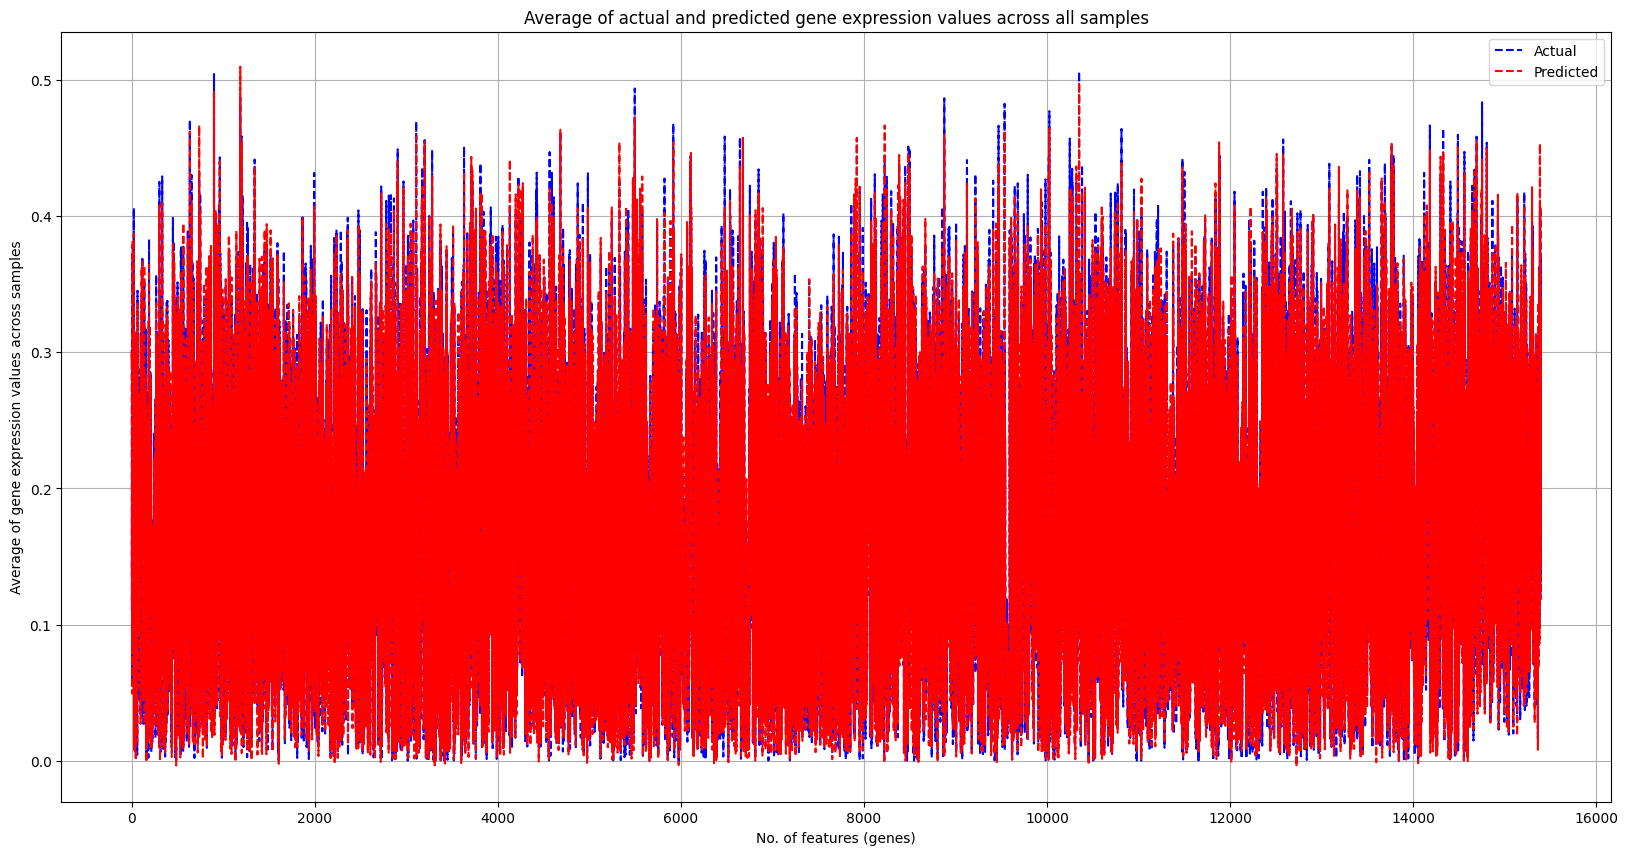

In [ ]:
act=actual_mean.values.flatten()
pred=pred_mean.values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.title('Average of actual and predicted gene expression values across all samples')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting first 100 features

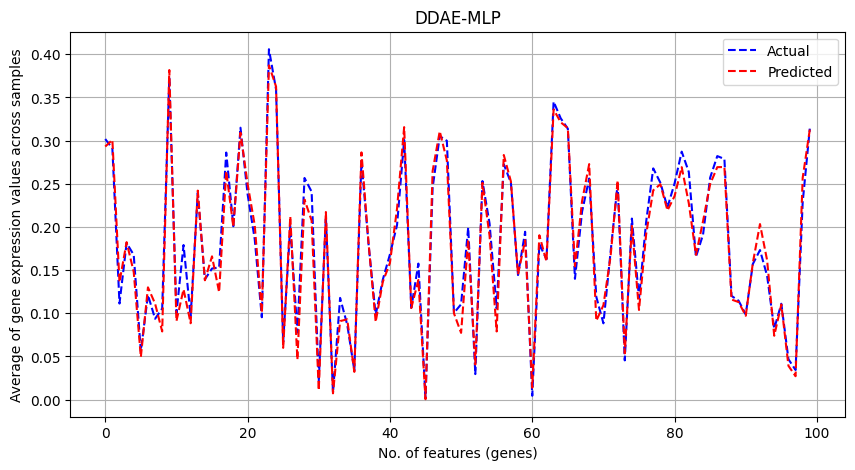

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('DDAE-MLP')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

Plotting correlation scatter plot for mean of actual Vs. mean of predicted gene expressions

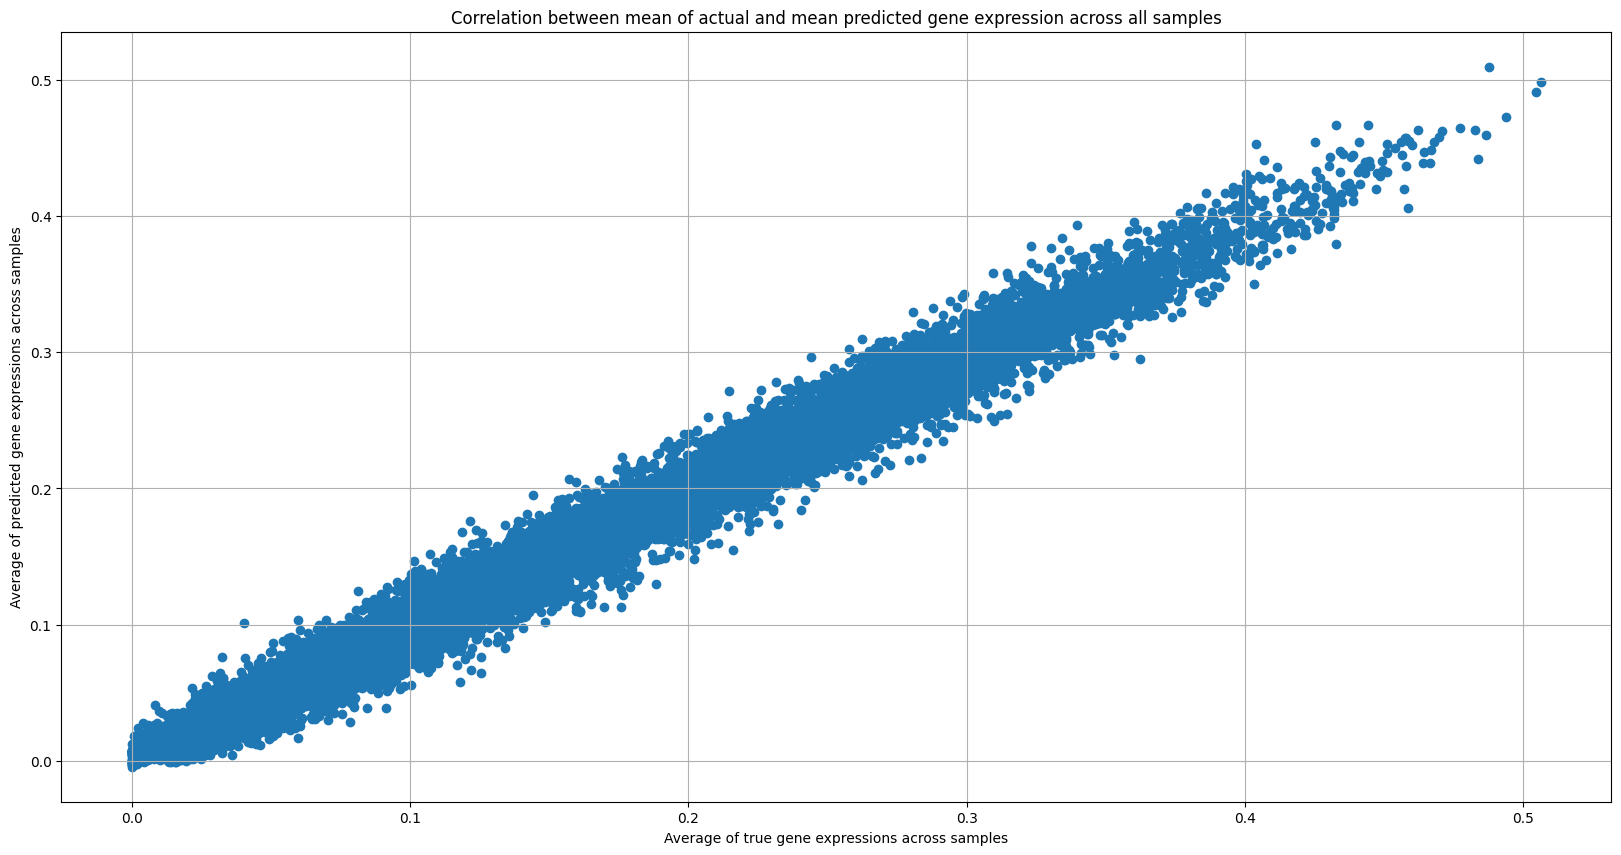

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(actual_mean, pred_mean)
plt.title('Correlation between mean of actual and mean predicted gene expression across all samples')
plt.xlabel('Average of true gene expressions across samples')
plt.ylabel('Average of predicted gene expressions across samples')
plt.grid(True)
plt.show()


# Classification of Tumor and Normal samples using MLP

Importing libraries

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

MLP-classifier

In [ ]:
num_hidden = encoding_dim2
with tf.device('/gpu:0'):
    x = autoencoder.get_layer('encoder2').output
    x = Dropout(0.2)(x)     # adding 20% dropout
    h = Dense(int(num_hidden * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)     # adding 50% dropout
    h = Dense(int(num_hidden * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)     # adding 50% dropout
    y = Dense(1, activation='sigmoid', name='predictions')(h)

    classifier = Model(inputs=autoencoder.inputs, outputs=y)
    # Compile model
    classifier.compile(loss='binary_crossentropy', optimizer='adam',
                   metrics=['accuracy'])
    # Fit the model
    classifier.fit(x_train, labels_train, epochs=25, batch_size=8)

    print('Now making predictions')
    predictions = classifier.predict(x_test)
    rounded_predictions = [round(x[0]) for x in predictions]

Epoch 1/25
41/41 [==============================] - 2s 4ms/step - loss: 1.7710 - accuracy: 0.8916
Epoch 2/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5354 - accuracy: 0.9102
Epoch 3/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5303 - accuracy: 0.9102
Epoch 4/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5331 - accuracy: 0.9102
Epoch 5/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5306 - accuracy: 0.9102
Epoch 6/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5299 - accuracy: 0.9102
Epoch 7/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5204 - accuracy: 0.9102
Epoch 8/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5421 - accuracy: 0.9102
Epoch 9/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5277 - accuracy: 0.9102
Epoch 10/25
41/41 [==============================] - 0s 4ms/step - loss: 1.5340 - accuracy: 0.9102
Epoch 11/25
41/41 [

Evaluating the model

In [ ]:
_, train_acc = classifier.evaluate(x_train, labels_train, verbose=0)
_, test_acc = classifier.evaluate(x_test, labels_test, verbose=0)
print('\nTraining accuracy: %.3f, Testing accuracy: %.3f' % (train_acc, test_acc))
print("Recall score = ",recall_score(labels_test, rounded_predictions))
cm = confusion_matrix(labels_test, rounded_predictions)
print("Confusion matrix:")
print(cm)
report = classification_report(labels_test, rounded_predictions)
print("classification_report")
print(report)


Training accuracy: 0.910, Testing accuracy: 0.877
Recall score =  1.0
Confusion matrix:
[[ 0 10]
 [ 0 71]]
classification_report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.88      1.00      0.93        71

    accuracy                           0.88        81
   macro avg       0.44      0.50      0.47        81
weighted avg       0.77      0.88      0.82        81



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparing regression results with other standard methods

Evaluating the mean of actual y values

In [ ]:
actual_mean = pd.DataFrame(y_test.mean(axis=0))

# 1. Linear Regression

Importing libraries

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
LinearRegression_afterNormalization = make_pipeline(StandardScaler(), LinearRegression())

Multi-output regression using Linear Regression (OLS) (sk-learn)

In [ ]:
with tf.device('/gpu:0'):
    linear_Regr = LinearRegression_afterNormalization
    linear_Regr.fit(x_train, y_train)
    y_pred = linear_Regr.predict(x_test)
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))
    y_mse=mean_squared_error(y_test, y_pred)
    y_r2score=r2_score(actual_mean, pred_mean)

In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error (y_test Vs. y_pred):  0.012691187256308724
r2 Score (y_test_mean Vs. y_pred_mean):  0.9830372174276676


Plotting first 100 features

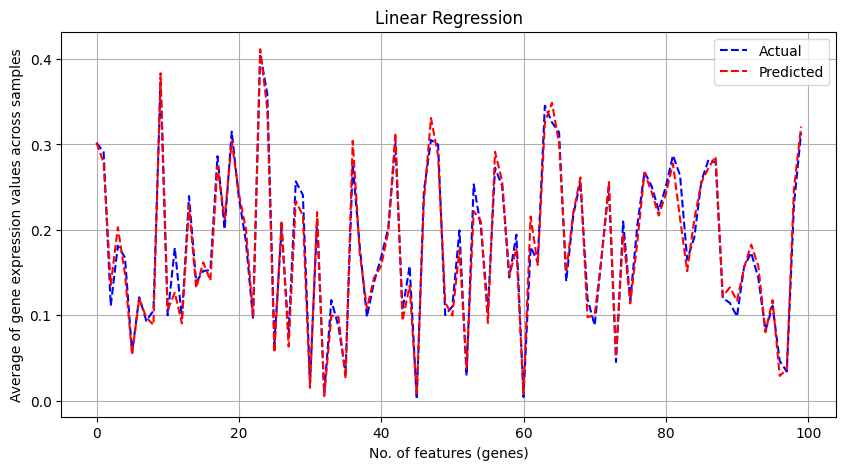

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Linear Regression')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

In [ ]:
# Normalize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 2. Ridge

Importing libraries

In [ ]:
from sklearn.linear_model import Ridge

Multi-output regression using Ridge (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for alp in [0.01,0.1,0.5,1,1.5]:
        print('Working with alpha = ',alp)
        Ridge_Regr = Ridge(alpha=alp)
        Ridge_Regr.fit(x_train_scaled, y_train)
        y_pred = Ridge_Regr.predict(x_test_scaled)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

Working with alpha =  0.01
Working with alpha =  0.1
Working with alpha =  0.5
Working with alpha =  1
Working with alpha =  1.5


In [ ]:
print("Mean Squared Error (y_test Vs. y_pred): ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error (y_test Vs. y_pred):  [0.012691181855502429, 0.012691133250856147, 0.012690917287035792, 0.012690647462651725, 0.012690377783013263]
r2 Score (y_test_mean Vs. y_pred_mean):  [0.9830372235992701, 0.9830372791410752, 0.983037525936556, 0.9830378343001459, 0.9830381425185611]


Plotting first 100 features

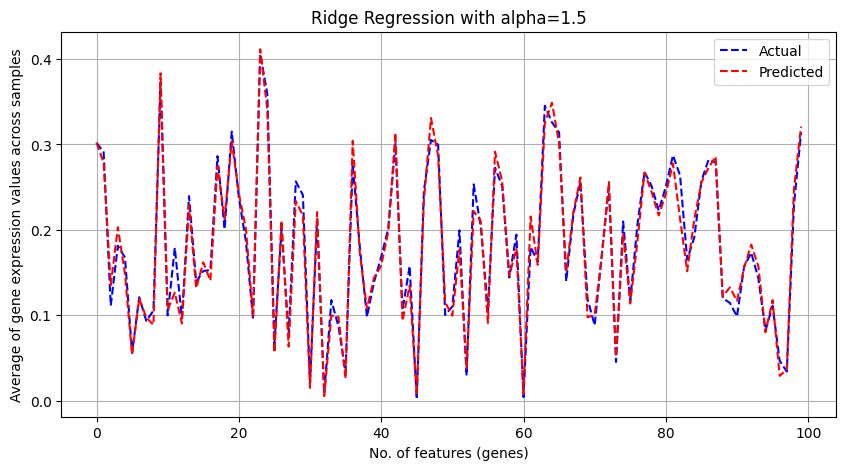

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('Ridge Regression with alpha=1.5')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 3. PCA - Random Forest (PCA-RF)

Importing libraries

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [ ]:
n=200
pca = PCA(n_components=n)
pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

Multi-output regression using Random Forest (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for est in [10,50,100,150,200]:
        print('estimators = ',est)
        rf_Regr = RandomForestRegressor(n_estimators=est, n_jobs=-1)
        rf_Regr.fit(x_train, y_train)
        y_pred = rf_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

estimators =  10
estimators =  50
estimators =  100
estimators =  150
estimators =  200


In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error:  [0.01519087030244551, 0.01426586436207717, 0.014151247719234821, 0.014161132612044377, 0.014034913521928049]
r2 Score (y_test_mean Vs. y_pred_mean):  [0.9788590373123396, 0.9787355657583541, 0.9787295119638074, 0.9781562325970473, 0.9781114652644196]


Plotting first 100 features

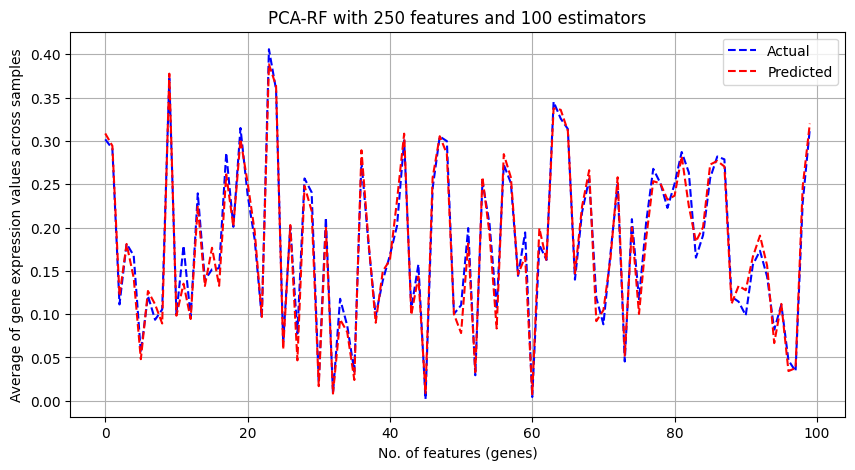

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('PCA-RF with 250 features and 100 estimators')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# 4. k-Nearest Neighbor (kNN)

Importing libraries

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

Multi-output regression using kNN (sk-learn)

In [ ]:
y_mse=[]
y_r2score=[]
with tf.device('/gpu:0'):
    for k in [5,10,15,20,25]:
        print('k=',k)
        knn_Regr = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
        knn_Regr.fit(x_train, y_train)
        y_pred = knn_Regr.predict(x_test)
        pred_mean = pd.DataFrame(y_pred.mean(axis=0))
        y_mse.append(mean_squared_error(y_test, y_pred))
        y_r2score.append(r2_score(actual_mean, pred_mean))

k= 5
k= 10
k= 15
k= 20
k= 25


In [ ]:
print("Mean Squared Error: ", y_mse)
print("r2 Score (y_test_mean Vs. y_pred_mean): ", y_r2score)

Mean Squared Error:  [0.015369430395439941, 0.01490834502994587, 0.014973072543411556, 0.015084498725550163, 0.015207788167441411]
r2 Score (y_test_mean Vs. y_pred_mean):  [0.936738072710555, 0.9338233043327414, 0.9329163580746117, 0.9309850316666544, 0.9300203104844752]


Plotting first 100 features

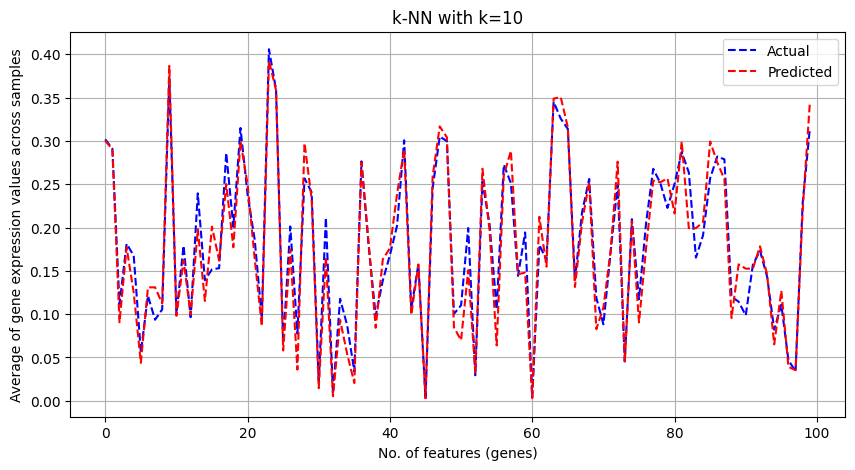

In [ ]:
act=actual_mean[0:100].values.flatten()
pred=pred_mean[0:100].values.flatten()

s1 = pd.Series(act)
s2 = pd.Series(pred)

plt.figure(figsize=(10,5))
ax = plt.subplot(111)
plt.title('k-NN with k=10')
plt.xlabel('No. of features (genes)')
plt.ylabel('Average of gene expression values across samples')
ax.plot(s1, 'b--', label='Actual')
ax.plot(s2, 'r--', label='Predicted')
ax.legend()
plt.grid(True)
plt.show()

# Comparison regression results from AE-MLP with PCA-MLP

Importing libraries

In [ ]:
from sklearn.decomposition import PCA

PCA-MLP

In [ ]:
n=100
with tf.device('/gpu:0'):
    #pca
    pca = PCA(n_components=n)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    # MLP Multi-output Regression code goes here...
    num = n
    input_data = Input(shape=(num,))
    x = Dropout(0.2)(input_data)             # adding 20% dropout
    h = Dense(int(num * 3), activation='relu', name='hidden1')(x)
    h = Dropout(0.5)(h)                        # adding 50% dropout
    h = Dense(int(num * 5), activation='relu', name='hidden2')(h)
    h = Dropout(0.5)(h)                        # adding 50% dropout
    y = Dense(num_out_neurons, activation='linear', name='prediction')(h)
    mlpRegressor = Model(inputs=input_data, outputs=y)

    # Compile model
    mlpRegressor.compile(loss='mse', optimizer='adam', metrics=['accuracy'])    # or loss='mae'
    # Fit the model
    print('training the MLP multi-output regressor')
    mlpRegressor.fit(x_train, y_train, epochs=50, batch_size=8)
    y_pred = mlpRegressor.predict(x_test)
    actual_mean = pd.DataFrame(y_test.mean(axis=0))
    pred_mean = pd.DataFrame(y_pred.mean(axis=0))

Printing results

In [ ]:
print('MSE: (Actual Vs. Predicted)', mean_squared_error(y_test, y_pred))
print('r^2 value: (Mean of actual Vs. Mean of Predicted)', r2_score(actual_mean, pred_mean))